In [452]:
!pip install torch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn作为matplotlib的补充，导入后会覆盖matplotlib的默认作图风格

from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score

In [11]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
df = pd.read_csv('./data/2010-2018_30*30网格划分.csv')

In [121]:
df

injection_vol  injection_psi  injection_depth_sum  depth_to_basement  \
0              0.0            0.0                  0.0                0.0   
1              0.0            0.0                  0.0                0.0   
2              0.0            0.0                  0.0                0.0   
3              0.0            0.0                  0.0                0.0   
4              0.0            0.0                  0.0                0.0   
..             ...            ...                  ...                ...   
895            0.0            0.0                  0.0                0.0   
896            0.0            0.0                  0.0                0.0   
897            0.0            0.0                  0.0                0.0   
898      1966271.0        33600.0              15757.0                0.0   
899       233380.0            0.0               6460.0                0.0   

     HF_number  HF_Base_Water_Volume  HF_Base_NoWater_Volume  \
0            0                   0.0                     0.0   
1            0                   0.0                     0.0   
2            0                   0.0                     0.0   
3            0                   0.0                     0.0   
4            0                   0.0                     0.0   
..         ...                   ...                     ...   
895          0                   0.0                     0.0   
896          0                   0.0                     0.0   
897          0                   0.0                     0.0   
898          0                   0.0                     0.0   
899          0                   0.0                     0.0   

     earthquake_occurence  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
..                    ...  
895                     0  
896                     0  
897                     0  
898                     0  
899                     0  

[900 rows x 8 columns]

In [122]:
df.rename(columns = {"earthquake_occurence":"class"}, inplace=True)
df['class'].value_counts()

0    508
1    392
Name: class, dtype: int64

In [123]:
labels = df['class']

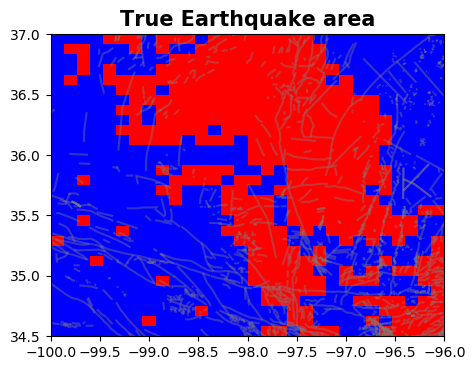

In [128]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1
# m, n = (41, 41)
x = np.linspace(-100, -96, m)
y = np.linspace(34.5, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(dpi=100)
ax1=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(34.5, 37, m) # y
lon = np.linspace(-100, -96, n) #x


plot_list = labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1


ax1.set_xlim(-100, -96)
ax1.set_ylim(34.5, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

# stepwise regression

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_columns = df.columns.tolist()[:-1]

def logistic_regression(x_columns):
    #特征features
    X = df[x_columns]
    #标签labels
    Y = df['class']

    X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8, random_state=42)

    #输出数据大小
    print('原始数据特征：',X.shape,
         '训练数据特征：',X_train.shape,
          '测试数据特征',X_test.shape)

    print('原始数据标签：',Y.shape,
         '训练数据标签：',y_train.shape,
          '测试数据标签',y_test.shape)

    feature_number = len(x_columns)

    #将训练数据特征转换成二维数组X行*1列
    X_train=X_train.values.reshape(-1,feature_number)
    #将测试数据特征转换成二维数组X行*1列
    X_test=X_test.values.reshape(-1,feature_number)


    #第一步：创建模型：逻辑回归
    model=LogisticRegression()
    #第二步：训练模型
    model.fit(X_train,y_train)

    #第三步: 评估模型：准确率
    print('test accuracy:', model.score(X_test,y_test))
    return model

In [138]:
## creating function to get model statistics
def get_stats():
    x = df[x_columns]
    y = df['class']
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [139]:
logistic_regression(x_columns)

原始数据特征： (900, 7) 训练数据特征： (720, 7) 测试数据特征 (180, 7)
原始数据标签： (900,) 训练数据标签： (720,) 测试数据标签 (180,)
test accuracy: 0.7111111111111111


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [140]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                  class   R-squared (uncentered):                   0.323
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              60.91
Date:                Tue, 27 Jul 2021   Prob (F-statistic):                    1.59e-71
Time:                        15:04:24   Log-Likelihood:                         -727.40
No. Observations:                 900   AIC:                                      1469.
Df Residuals:                     893   BIC:                                      1502.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [141]:
x_columns.remove("HF_Base_Water_Volume")
logistic_regression(x_columns)
get_stats()


原始数据特征： (900, 6) 训练数据特征： (720, 6) 测试数据特征 (180, 6)
原始数据标签： (900,) 训练数据标签： (720,) 测试数据标签 (180,)
test accuracy: 0.6611111111111111
                                 OLS Regression Results                                
Dep. Variable:                  class   R-squared (uncentered):                   0.323
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              71.02
Date:                Tue, 27 Jul 2021   Prob (F-statistic):                    2.27e-72
Time:                        15:04:24   Log-Likelihood:                         -727.63
No. Observations:                 900   AIC:                                      1467.
Df Residuals:                     894   BIC:                                      1496.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                           

In [142]:
x_columns.remove("injection_vol")
logistic_regression(x_columns)
get_stats()

原始数据特征： (900, 5) 训练数据特征： (720, 5) 测试数据特征 (180, 5)
原始数据标签： (900,) 训练数据标签： (720,) 测试数据标签 (180,)
test accuracy: 0.6722222222222223
                                 OLS Regression Results                                
Dep. Variable:                  class   R-squared (uncentered):                   0.322
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              85.05
Date:                Tue, 27 Jul 2021   Prob (F-statistic):                    3.66e-73
Time:                        15:04:25   Log-Likelihood:                         -728.09
No. Observations:                 900   AIC:                                      1466.
Df Residuals:                     895   BIC:                                      1490.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                           

In [143]:
x_columns.remove("HF_Base_NoWater_Volume")
logistic_regression(x_columns)
get_stats()

原始数据特征： (900, 4) 训练数据特征： (720, 4) 测试数据特征 (180, 4)
原始数据标签： (900,) 训练数据标签： (720,) 测试数据标签 (180,)
test accuracy: 0.7
                                 OLS Regression Results                                
Dep. Variable:                  class   R-squared (uncentered):                   0.321
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              105.9
Date:                Tue, 27 Jul 2021   Prob (F-statistic):                    6.68e-74
Time:                        15:04:26   Log-Likelihood:                         -728.79
No. Observations:                 900   AIC:                                      1466.
Df Residuals:                     896   BIC:                                      1485.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
       

In [147]:
labels = df['class']
feature_number = len(x_columns)
X = df[x_columns].values
model = logistic_regression(x_columns)
out_classes = model.predict(X.reshape(-1,feature_number))

原始数据特征： (900, 4) 训练数据特征： (720, 4) 测试数据特征 (180, 4)
原始数据标签： (900,) 训练数据标签： (720,) 测试数据标签 (180,)
test accuracy: 0.7


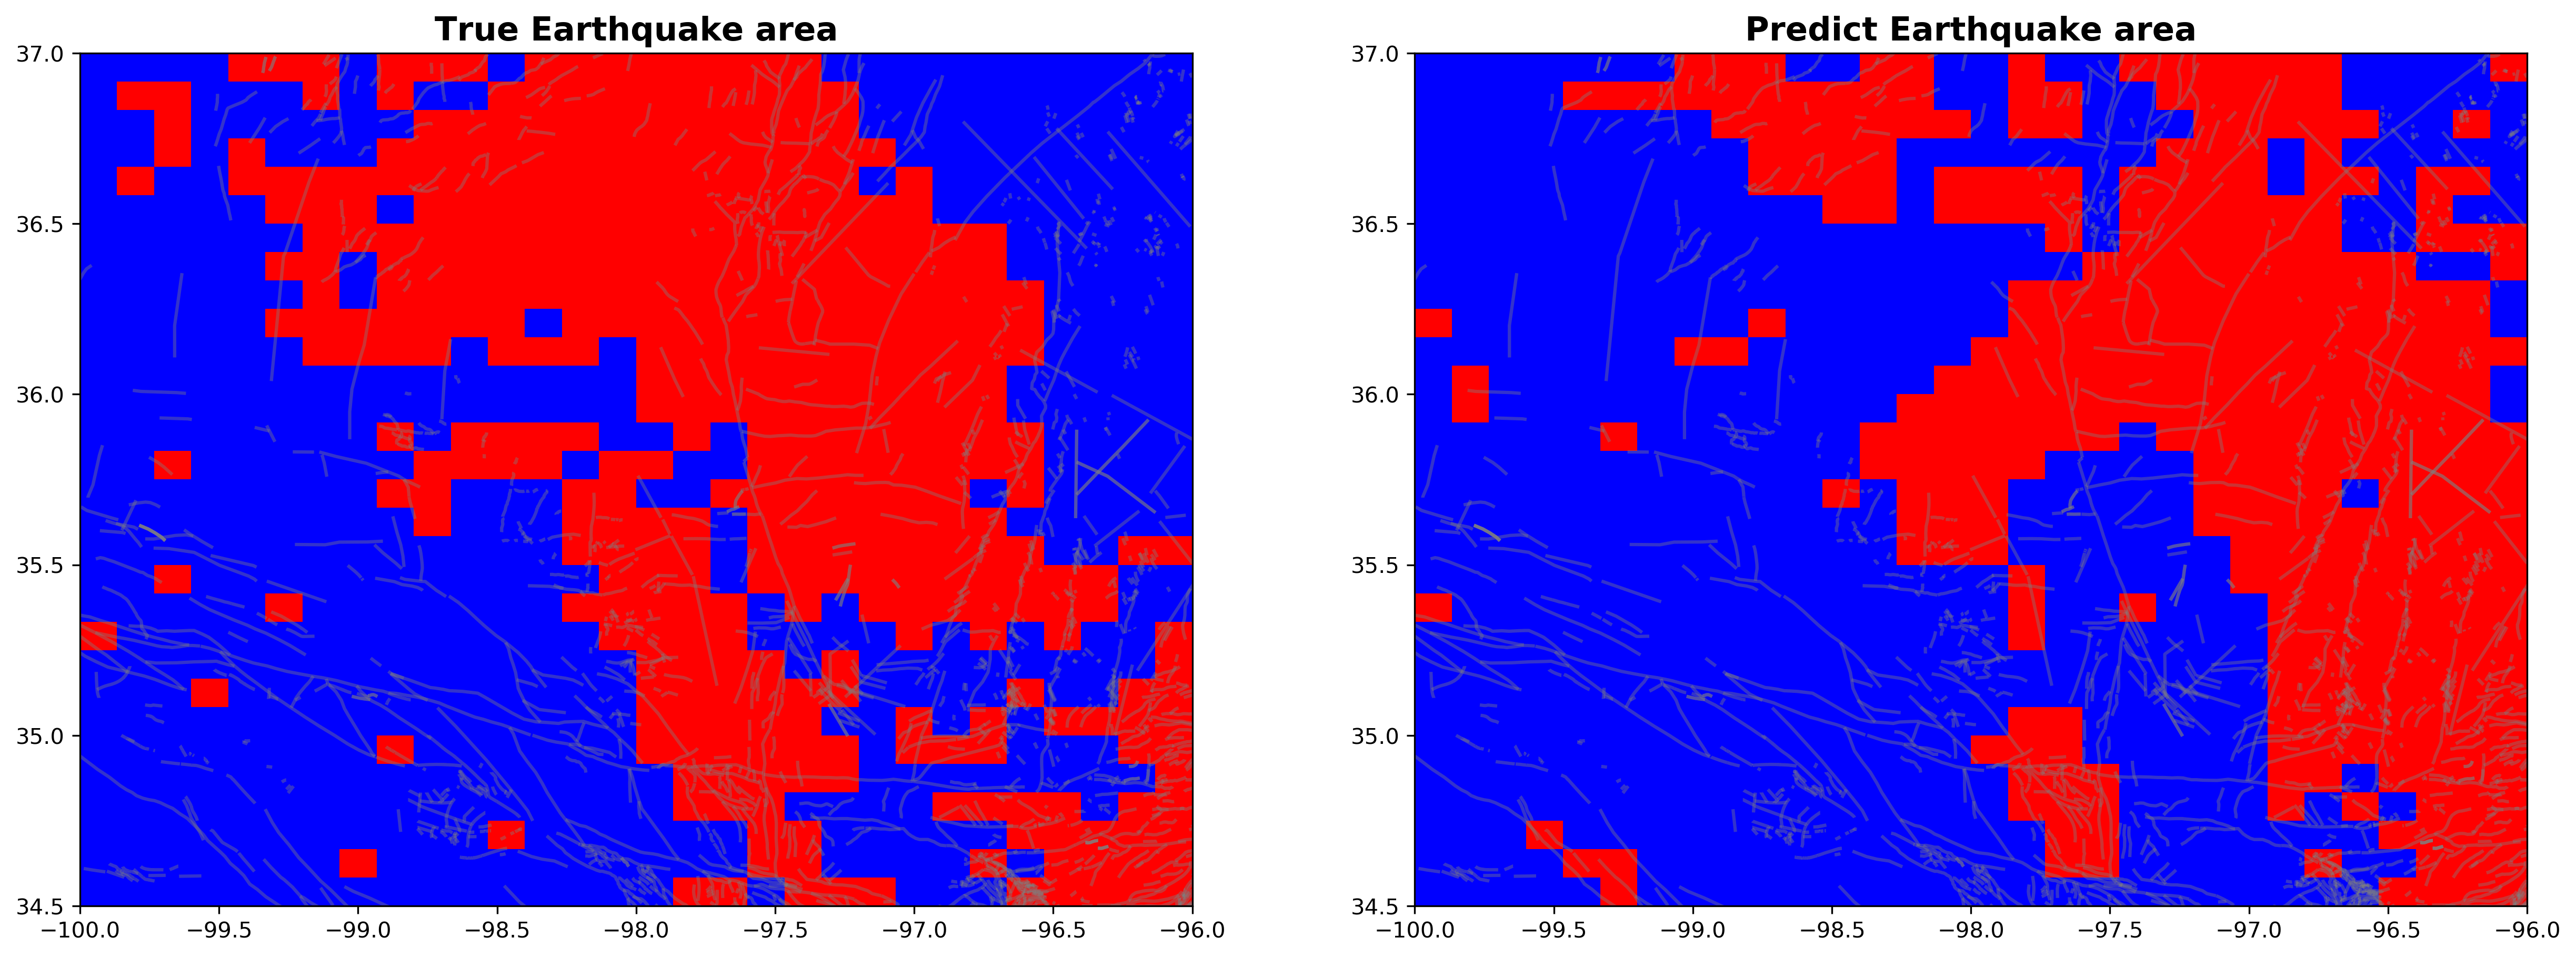

In [148]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-100, -96, m)
y = np.linspace(34.5, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(34.5, 37, m) # y
lon = np.linspace(-100, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

plot_list = out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

ax1.set_xlim(-100, -96)
ax1.set_ylim(34.5, 37)
ax2.set_xlim(-100, -96)
ax2.set_ylim(34.5, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
ax2.set_title('Predict Earthquake area', fontsize=15,fontweight='bold')
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

# 构建神经网络模型

In [149]:
x_columns

['injection_psi', 'injection_depth_sum', 'depth_to_basement', 'HF_number']

In [150]:
features = df[x_columns]
target = df['class']

In [151]:
# feature_names = df.columns.tolist()[:-1]

In [152]:
feature_names = features.columns.tolist()
print(feature_names)

['injection_psi', 'injection_depth_sum', 'depth_to_basement', 'HF_number']


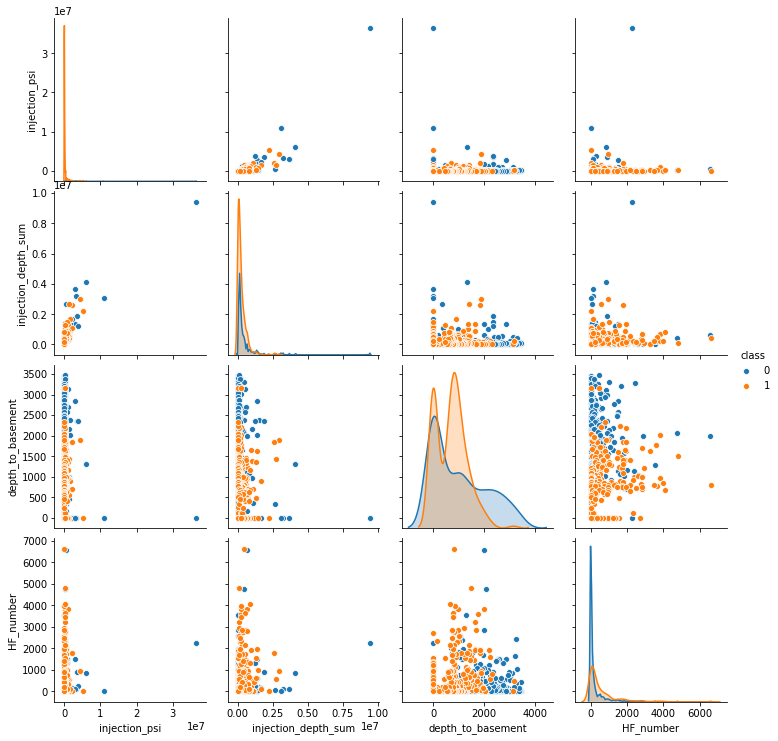

In [153]:
sns.pairplot(df, hue='class', vars=feature_names)  # hue : 使用指定变量为分类变量画图；vars : 与data使用，否则使用data的全部变量
plt.show()  # 仍然使用matplotlib的显示函数

In [200]:
class Net(nn.Module):
    def __init__(self,n_input, n_output):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_input, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 12)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(12, 8)
        self.sigmoid3 = nn.Sigmoid()
        self.linear4 = nn.Linear(8, n_output)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        lin2_out = self.linear2(sigmoid_out1)
        sigmoid_out2 = self.sigmoid2(lin2_out)
        lin3_out = self.linear3(sigmoid_out2)
        sigmoid_out3 = self.sigmoid3(lin3_out)
        return self.linear4(sigmoid_out3)

In [201]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, feature_number).float())
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, feature_number).float())
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [202]:
# 测试模型是否可用
# x = torch.rand((100,feature_number))
# print(x)
# model = Net(feature_number,20,2)
# result = model(x)
# print (result)
# model = model.to(device)

# Train the model, validation and evaluation

In [214]:
# Define the hyperparameters
seed = 42
lr = 1e-2
momentum = 0.8
batch_size = 8
test_batch_size = 8
n_epochs = 100

feature_number = len(feature_names)
model = Net(feature_number,2)

In [215]:
Y = target.values
X = features.values
data_tensor = TensorDataset(torch.tensor(X), torch.tensor(Y))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train = X[indices[0]]
X_test = X[indices[1]]
Y_train = Y[indices[0]]
Y_test = Y[indices[1]]

mean_value = np.mean(X[indices[0]], axis=0)
std_value = np.std(X[indices[0]], axis=0)


for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [216]:
print(len(train_dataset))
print(len(val_dataset))

720
180


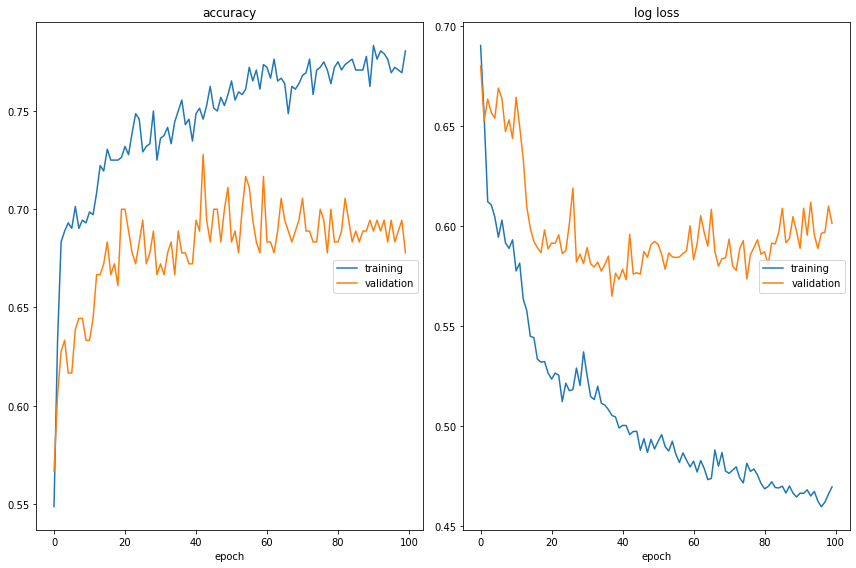

accuracy
	training         	 (min:    0.549, max:    0.783, cur:    0.781)
	validation       	 (min:    0.567, max:    0.728, cur:    0.678)
log loss
	training         	 (min:    0.460, max:    0.690, cur:    0.470)
	validation       	 (min:    0.565, max:    0.680, cur:    0.601)

Avg. Test Loss: 0.601  Avg. Test Accuracy: 0.678


In [217]:
set_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()


test_loss, test_accuracy = validate(model, criterion, test_loader)  
print("")
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

In [218]:
model.eval()
test_features = X_test
test_labels = Y_test
test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor.float())
out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.6777777777777778


# Feature Importance

In [219]:
from captum.attr import FeaturePermutation, IntegratedGradients

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(18,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

Average Feature Importances
injection_psi :  0.099
injection_depth_sum :  -0.366
depth_to_basement :  -0.495
HF_number :  -0.372


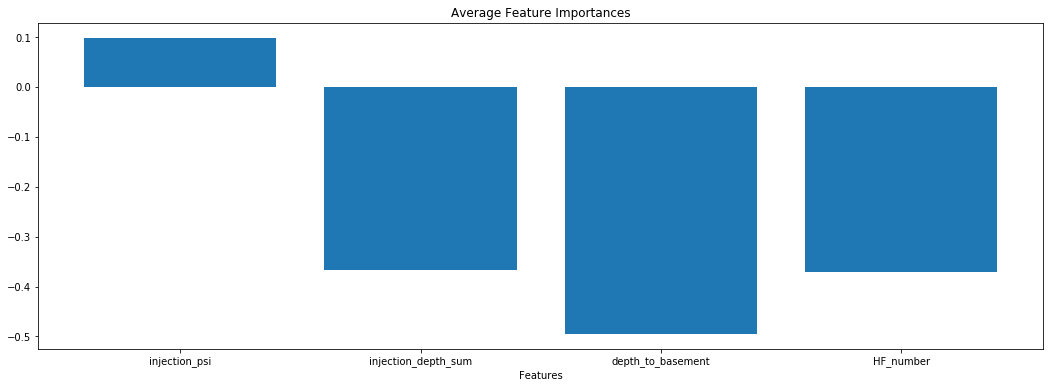

In [220]:
ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor.float(),target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
visualize_importances(feature_names, np.mean(attr, axis=0))

# Save the model

In [210]:
model.eval()
model.parameters()
path = "./model/EarthquakePredict_2010-2018_40*40.pt"
torch.save(model.state_dict,path)

# 在所有数据集上复现

In [221]:
model.eval()
test_features = X
test_labels = Y
test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor.float()).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.5466666666666666


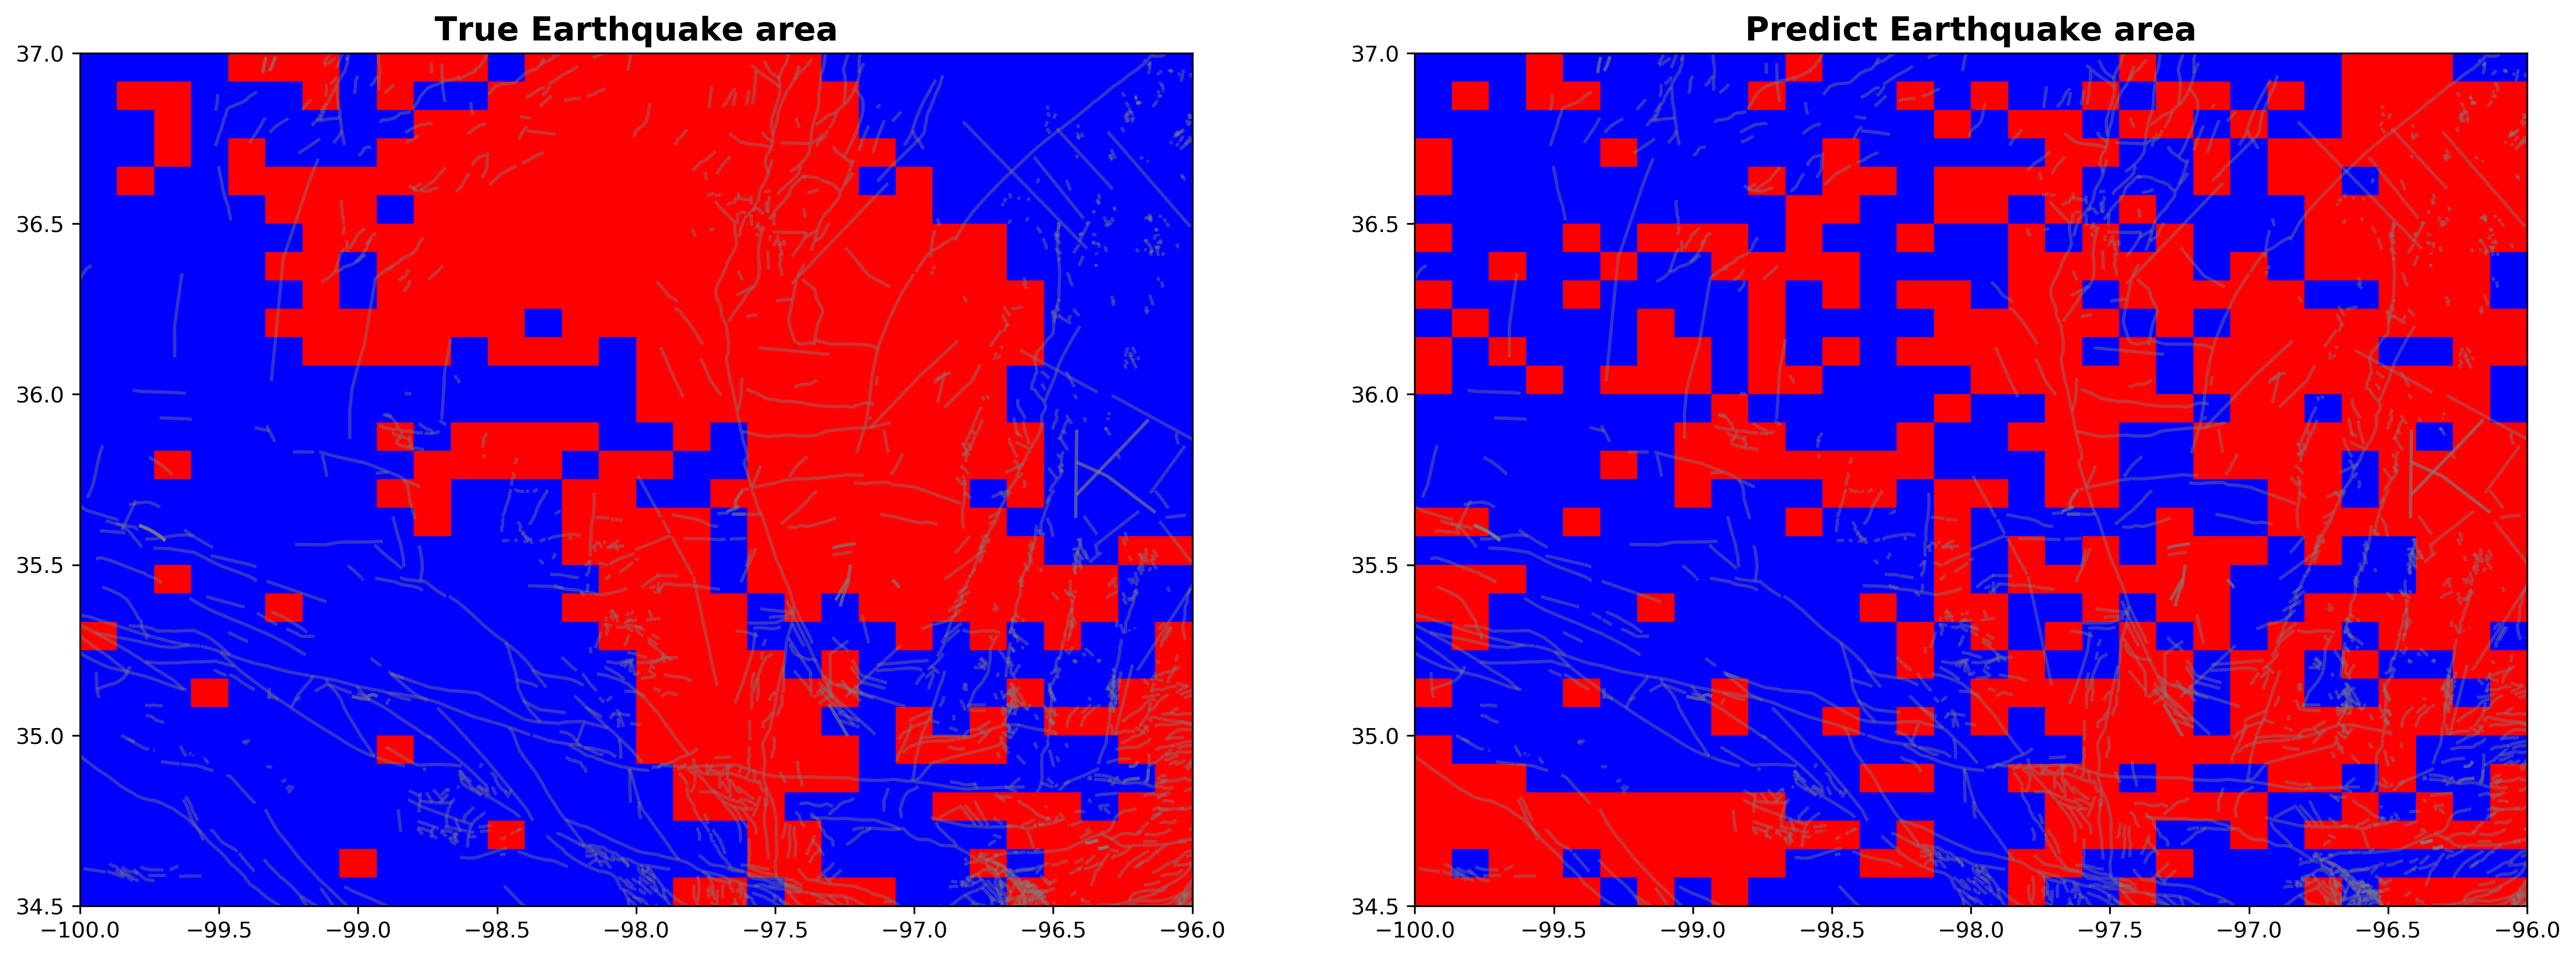

In [222]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-100, -96, m)
y = np.linspace(34.5, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(34.5, 37, m) # y
lon = np.linspace(-100, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

plot_list = out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

ax1.set_xlim(-100, -96)
ax1.set_ylim(34.5, 37)
ax2.set_xlim(-100, -96)
ax2.set_ylim(34.5, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
ax2.set_title('Predict Earthquake area', fontsize=15,fontweight='bold')
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()